<a href="https://colab.research.google.com/github/vitroid/GenIce-core/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## for Google Colaboratory

In [ ]:
%pip install git+https://github.com/vitroid/GenIce-core.git pairlist

## 1. Make an arbitrary graph directed.

In [ ]:
import networkx as nx
import matplotlib
import genice_core

g = nx.dodecahedral_graph()  # dodecahedral 20mer
pos = nx.spring_layout(g)

# set orientations of the hydrogen bonds.
dg = genice_core.ice_graph(g)

nx.draw_networkx(dg, pos)

## 2. And depolarized.

In [ ]:
import networkx as nx
import matplotlib
import genice_core
from logging import getLogger, DEBUG, basicConfig, INFO

basicConfig(level=INFO)
logger=getLogger()

g = nx.dodecahedral_graph()  # dodecahedral 20mer
pos = nx.spring_layout(g)

# set orientations of the hydrogen bonds.
# Minimize the net dipole moment.
dg = genice_core.ice_graph(g, pos, dipoleOptimizationCycles=100)

nx.draw_networkx(dg, pos)

## 3. Under the periodic boundary condition.

In [ ]:
from logging import DEBUG, INFO, basicConfig, getLogger

import networkx as nx
import numpy as np

# import py3Dmol
import pairlist
from genice_core import ice_graph

logger = getLogger()
basicConfig(level=INFO)

# a sample structure of ice 1h.
# The first line specifies the cell dimension, and atomic positions (absolute) follows.
pos = np.loadtxt("ice1h.txt").reshape(-1, 3)
cell, coords = pos[0], pos[1:]

# prepare the cell matrix
cellmat = np.diag(cell)

# make the fractional coordinates
fracCoords = coords / cell

# make a graph from the proximity
g = nx.Graph([(i, j) for i, j, _ in pairlist.pairs_iter(fracCoords, 0.3, cellmat)])

# set orientations of the hydrogen bonds.
dg = ice_graph(
    g, vertexPositions=fracCoords, isPeriodicBoundary=True, dipoleOptimizationCycles=100
)
dg

## Benchmark tests

### Scalability

In [41]:
import numpy as np


def diamond(N: int) -> np.ndarray:
    """Diamond lattice. == ice 1c

    Args:
        N (int): Number of unit cells per an edge of the simulation cell.

    Returns:
        np.ndarray: atomic positions in the fractional coordinate.
    """
    # make an FCC
    xyz = (
        np.array(
            [
                (x, y, z)
                for x in range(N)
                for y in range(N)
                for z in range(N)
                if (x + y + z) % 2 == 0
            ]
        )
    )
    xyz = np.vstack([xyz, xyz + 0.5])
    return xyz / N

8
12
16
24
36
48
8
12
16
24
36
48
8
12


KeyboardInterrupt: 

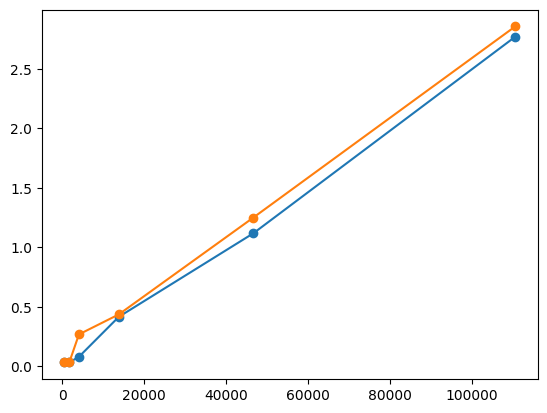

In [48]:
import pairlist as pl
import networkx as nx
import genice_core
import time
import matplotlib.pyplot as plt

np.random.seed(999)

for doped, depol in ((False, 0), (False, 100), (True, 100)):
    X = []
    Y = []
    for N in (8, 12, 16, 24, 36, 48): #, 64, 96):
        print(N)
        
        pos = diamond(N)
        cell = np.diag([N, N, N])

        # adjacency graph
        g = nx.Graph(
            [
                (i, j)
                for i, j in pl.pairs_iter(pos, 1, cell, fractional=True, distance=False)
            ]
        )

        fixed = nx.DiGraph()
        if doped:
            for nei in g[0]:
                fixed.add_edge(0, nei)
            c = len(g.nodes()) // 2
            if c > 1000:
                c = 1000
            for nei in g[c]:
                fixed.add_edge(nei, c)

        now = time.time()
        dg = genice_core.ice_graph(
            g,
            vertexPositions=pos,
            dipoleOptimizationCycles=depol,
            isPeriodicBoundary=True,
            fixedEdges=fixed,
        )
        X.append(len(g))
        Y.append(time.time() - now)

    plt.plot(X, Y, "o-", label=f"depol loop={depol} doped={doped}")

plt.xscale("log")
plt.yscale("log")
X = np.logspace(3, 5, 10)
Y = X / 20000
plt.plot(X, Y, "k:", label="linear")
plt.xlabel("Number of nodes")
plt.ylabel("Time / s")
plt.legend()

### Doped ice

Comparison with original GenIce 2.1 using Buch's algorithm.

In [34]:
%pip install git+https://github.com/vitroid/GenIce.git#2.1.7.2

  Cloning https://github.com/vitroid/GenIce.git to /private/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/pip-req-build-htdh8mqy
  Running command git clone --filter=blob:none --quiet https://github.com/vitroid/GenIce.git /private/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/pip-req-build-htdh8mqy
  Resolved https://github.com/vitroid/GenIce.git to commit 554fa424ca3d6d0370deedb0b3f82cd706bdab32
  Preparing metadata (setup.py) ... done
  Created wheel for GenIce2: filename=GenIce2-2.1.7.2-py2.py3-none-any.whl size=814067 sha256=0d2d806144480aef6746f7bb8cfce532a0dc1da247b773099c2a2c26a7e2d63f
  Stored in directory: /private/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/pip-ephem-wheel-cache-lf39p3tg/wheels/e7/05/ff/8e62d9f65694d5f17412fb6af5a438fd678e12a52e99e639b1
Successfully built GenIce2
  Attempting uninstall: GenIce2
    Found existing installation: GenIce2 2.2
    Uninstalling GenIce2-2.2:
      Successfully uninstalled GenIce2-2.2

[notice] A new release of pip is availab

In [35]:
! time genice2 1c -r 30 30 30 --cation 0=Li --anion 1000=F --depol=optimal > doped1c.gro
# 65 sec for stages 3 and 4 on Apple M1


INFO ['1000=F']
INFO __init__: Constructor of GenIce.
INFO   
INFO   Command line: /Users/matto/.local/share/virtualenvs/GenIce-core-RY0sKM3p/bin/genice2 1c -r 30 30 30 --cation 0=Li --anion 1000=F --depol=optimal
INFO No rotmatrices in lattice
INFO Cell dimension:
INFO   a = 4.0
INFO   b = 4.0
INFO   c = 4.0
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Bond length (specified): 1.9
INFO Target Density: 0.92
INFO Original Density: 0.0037363002324809044
INFO Bond length (scaled, nm): 0.3031365108343017
INFO __init__: end.
INFO __init__: 11 ms
INFO Stage1: Replicate water molecules to make a repeated cell.
INFO   Number of water molecules: 216000
INFO   Number of water nodes: 8
INFO Cell dimension:
INFO   a = 0.6381821280722142
INFO   b = 0.6381821280722142
INFO   c = 0.6381821280722142
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Stage1: end.
INFO Stage1: 21 ms
INFO Stage2: Make a random graph and replicate.
INFO replicate_graph: 1666 ms
INFO   Anionize: {1000: 'F'}.
INFO

In [36]:
! time genice2 1c -r 30 30 30 --depol=strict > doped1c.gro
# 6 sec for stage 3D on Apple M1


INFO __init__: Constructor of GenIce.
INFO   
INFO   Command line: /Users/matto/.local/share/virtualenvs/GenIce-core-RY0sKM3p/bin/genice2 1c -r 30 30 30 --depol=strict
INFO No rotmatrices in lattice
INFO Cell dimension:
INFO   a = 4.0
INFO   b = 4.0
INFO   c = 4.0
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Bond length (specified): 1.9
INFO Target Density: 0.92
INFO Original Density: 0.0037363002324809044
INFO Bond length (scaled, nm): 0.3031365108343017
INFO __init__: end.
INFO __init__: 0 ms
INFO Stage1: Replicate water molecules to make a repeated cell.
INFO   Number of water molecules: 216000
INFO   Number of water nodes: 8
INFO Cell dimension:
INFO   a = 0.6381821280722142
INFO   b = 0.6381821280722142
INFO   c = 0.6381821280722142
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Stage1: end.
INFO Stage1: 9 ms
INFO Stage2: Make a random graph and replicate.
INFO replicate_graph: 1277 ms
INFO Stage2: end.
INFO Stage2: 1277 ms
INFO   Number of pre-oriented hydrogen bond

In [37]:
! pip install git+https://github.com/vitroid/GenIce.git@genice-core

  Cloning https://github.com/vitroid/GenIce.git (to revision genice-core) to /private/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/pip-req-build-q5xec139
  Running command git clone --filter=blob:none --quiet https://github.com/vitroid/GenIce.git /private/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/pip-req-build-q5xec139


  Running command git checkout -b genice-core --track origin/genice-core
  Switched to a new branch 'genice-core'
  branch 'genice-core' set up to track 'origin/genice-core'.
  Resolved https://github.com/vitroid/GenIce.git to commit e9e687ba2e3f58cb5231fa4c003fb7965653bcf0
  Preparing metadata (setup.py) ... done
  Created wheel for GenIce2: filename=GenIce2-2.2-py2.py3-none-any.whl size=805760 sha256=1c9a019db77ff709a2c0d51b8de17e7de06f04345c5d50bbc565ee8a4064c022
  Stored in directory: /private/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/pip-ephem-wheel-cache-7hx2cz_5/wheels/e8/94/ea/bff3abe4529095b29ff3f1b5efc58463d630c2309b4eef2611
Successfully built GenIce2
  Attempting uninstall: GenIce2
    Found existing installation: GenIce2 2.1.7.2
    Uninstalling GenIce2-2.1.7.2:
      Successfully uninstalled GenIce2-2.1.7.2

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [38]:
! time genice2 1c -r 30 30 30 --cation 0=Li --anion 1000=F --depol=optimal > doped1c.gro
# 14.6 sec for stage 3D on Apple M1


INFO ['1000=F']
INFO __init__: Constructor of GenIce.
INFO   
INFO   Command line: /Users/matto/.local/share/virtualenvs/GenIce-core-RY0sKM3p/bin/genice2 1c -r 30 30 30 --cation 0=Li --anion 1000=F --depol=optimal
INFO Cell dimension:
INFO   a = 4.0
INFO   b = 4.0
INFO   c = 4.0
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Bond length (specified): 1.9
INFO Target Density: 0.92
INFO Original Density: 0.0037363002324809044
INFO Bond length (scaled, nm): 0.3031365108343017
INFO __init__: end.
INFO __init__: 13 ms
INFO Stage1: Replicate water molecules to make a repeated cell.
INFO   Number of water molecules: 216000
INFO   Number of water nodes: 8
INFO Cell dimension:
INFO   a = 0.6381821280722142
INFO   b = 0.6381821280722142
INFO   c = 0.6381821280722142
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Stage1: end.
INFO Stage1: 34 ms
INFO Stage2: Make a random graph and replicate.
INFO replicate_graph: 776 ms
INFO   Anionize: {1000: 'F'}.
INFO   Cationize: {0: 'Li'}.
INFO St

In [40]:
! time genice2 1c -r 30 30 30 --depol=optimal > doped1c.gro
# 8.7 sec for stage 3D on Apple M1


INFO __init__: Constructor of GenIce.
INFO   
INFO   Command line: /Users/matto/.local/share/virtualenvs/GenIce-core-RY0sKM3p/bin/genice2 1c -r 30 30 30 --depol=optimal
INFO Cell dimension:
INFO   a = 4.0
INFO   b = 4.0
INFO   c = 4.0
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Bond length (specified): 1.9
INFO Target Density: 0.92
INFO Original Density: 0.0037363002324809044
INFO Bond length (scaled, nm): 0.3031365108343017
INFO __init__: end.
INFO __init__: 0 ms
INFO Stage1: Replicate water molecules to make a repeated cell.
INFO   Number of water molecules: 216000
INFO   Number of water nodes: 8
INFO Cell dimension:
INFO   a = 0.6381821280722142
INFO   b = 0.6381821280722142
INFO   c = 0.6381821280722142
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Stage1: end.
INFO Stage1: 26 ms
INFO Stage2: Make a random graph and replicate.
INFO replicate_graph: 791 ms
INFO Stage2: end.
INFO Stage2: 792 ms
INFO   Number of pre-oriented hydrogen bonds: 0
INFO   Number of unoriente

In [29]:
! pip install py3dmol


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [30]:
! time genice2 1c -r 4 4 4 --cation 0=Li --anion 10=F --depol=optimal > doped1c.gro

INFO ['10=F']
INFO __init__: Constructor of GenIce.
INFO   
INFO   Command line: /Users/matto/.local/share/virtualenvs/GenIce-core-RY0sKM3p/bin/genice2 1c -r 4 4 4 --cation 0=Li --anion 10=F --depol=optimal
INFO Cell dimension:
INFO   a = 4.0
INFO   b = 4.0
INFO   c = 4.0
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Bond length (specified): 1.9
INFO Target Density: 0.92
INFO Original Density: 0.0037363002324809044
INFO Bond length (scaled, nm): 0.3031365108343017
INFO __init__: end.
INFO __init__: 1 ms
INFO Stage1: Replicate water molecules to make a repeated cell.
INFO   Number of water molecules: 512
INFO   Number of water nodes: 8
INFO Cell dimension:
INFO   a = 0.6381821280722142
INFO   b = 0.6381821280722142
INFO   c = 0.6381821280722142
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Stage1: end.
INFO Stage1: 27 ms
INFO Stage2: Make a random graph and replicate.
INFO replicate_graph: 2 ms
INFO   Anionize: {10: 'F'}.
INFO   Cationize: {0: 'Li'}.
INFO Stage2: end.
INFO

In [31]:
# なぜか表示されない
import py3Dmol

# show
view = py3Dmol.view()
view.addModel("doped1c.gro")
view.setStyle({'stick':{}})
view.addUnitCell()
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Normal ice

Improvement from GenIce2.1

In [32]:
! pip install git+https://github.com/vitroid/GenIce.git#2.1.7.2
! time genice2 1c -r 30 30 30 > doped1c.gro

  Cloning https://github.com/vitroid/GenIce.git to /private/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/pip-req-build-2zqg2g6a
  Running command git clone --filter=blob:none --quiet https://github.com/vitroid/GenIce.git /private/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/pip-req-build-2zqg2g6a
  Resolved https://github.com/vitroid/GenIce.git to commit 554fa424ca3d6d0370deedb0b3f82cd706bdab32
  Preparing metadata (setup.py) ... done
  Created wheel for GenIce2: filename=GenIce2-2.1.7.2-py2.py3-none-any.whl size=814067 sha256=82a783a135bbfa742223481773bac0a722e3d9434fd199303faa29caebc1a28b
  Stored in directory: /private/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/pip-ephem-wheel-cache-xc9__7tj/wheels/e7/05/ff/8e62d9f65694d5f17412fb6af5a438fd678e12a52e99e639b1
Successfully built GenIce2
  Attempting uninstall: GenIce2
    Found existing installation: GenIce2 2.2
    Uninstalling GenIce2-2.2:
      Successfully uninstalled GenIce2-2.2

[notice] A new release of pip is availab

In [33]:
! pip uninstall -y genice2
! pip install git+https://github.com/vitroid/GenIce.git@genice-core
! time genice2 1c -r 30 30 30 > doped1c.gro
! genice2 --version

Found existing installation: GenIce2 2.1.7.2
Uninstalling GenIce2-2.1.7.2:
  Successfully uninstalled GenIce2-2.1.7.2
  Cloning https://github.com/vitroid/GenIce.git (to revision genice-core) to /private/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/pip-req-build-cpdxubo4
  Running command git clone --filter=blob:none --quiet https://github.com/vitroid/GenIce.git /private/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/pip-req-build-cpdxubo4
  Running command git checkout -b genice-core --track origin/genice-core
  Switched to a new branch 'genice-core'
  branch 'genice-core' set up to track 'origin/genice-core'.
  Resolved https://github.com/vitroid/GenIce.git to commit e9e687ba2e3f58cb5231fa4c003fb7965653bcf0
  Preparing metadata (setup.py) ... done
  Created wheel for GenIce2: filename=GenIce2-2.2-py2.py3-none-any.whl size=805760 sha256=c85b68c0731217b4f28e3def632bbc6c1502b74639b3cc58acc4149e4eb048fc
  Stored in directory: /private/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/p

## Debug and Tuning

In [ ]:
import pairlist as pl
import networkx as nx
import genice_core
import time
import matplotlib.pyplot as plt
from logging import getLogger, INFO, basicConfig

logger = getLogger()
basicConfig(level=INFO)


def main():
    np.random.seed(999)

    N = 64
    pos = diamond(N)
    cell = np.diag([N, N, N])
    # adjacency graph
    g = nx.Graph(
        [
            (i, j)
            for i, j in pl.pairs_iter(pos, 1, cell, fractional=True, distance=False)
        ]
    )

    now = time.time()
    dg = genice_core.ice_graph(
        g,
        vertexPositions=pos,
        dipoleOptimizationCycles=100,
    )


import cProfile

cProfile.run("main()", filename="main.prof")

In [ ]:
import pstats

sts = pstats.Stats("main.prof")
sts.strip_dirs().sort_stats(-1).print_stats()